# Custom Models and Estimators

This notebook demonstrates how to extend the LRDBenchmark library with custom data models and estimators, showing the extensibility and flexibility of the framework.

## Overview

LRDBenchmark is designed to be highly extensible, allowing users to add their own data models and estimators. This notebook covers:

1. **Understanding the Base Classes**: How the framework is structured
2. **Custom Data Models**: Creating new stochastic processes
3. **Custom Estimators**: Implementing new estimation methods
4. **Integration**: Making custom components work with the benchmark system
5. **Best Practices**: Guidelines for extensibility

## Table of Contents

1. [Setup and Imports](#setup)
2. [Understanding Base Classes](#base-classes)
3. [Custom Data Model Example](#custom-data-model)
4. [Custom Classical Estimator](#custom-classical)
5. [Custom ML Estimator](#custom-ml)
6. [Integration with Benchmark System](#integration)
7. [Testing and Validation](#testing)
8. [Best Practices](#best-practices)
9. [Summary and Next Steps](#summary)


## 1. Setup and Imports {#setup}

First, let's import all necessary libraries and examine the base classes that we'll be extending.


In [8]:
# Standard scientific computing imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
import time
import warnings
warnings.filterwarnings('ignore')

# Set JAX to use CPU to avoid CUDA issues
import os
os.environ['JAX_PLATFORMS'] = 'cpu'

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Set random seed for reproducibility
np.random.seed(42)

# Import LRDBenchmark base classes
from lrdbenchmark.models.data_models.base_model import BaseModel
from lrdbenchmark.analysis.machine_learning.ml_model_factory import MLModelFactory, ModelConfig
from lrdbenchmark.analysis.machine_learning.neural_network_factory import NeuralNetworkFactory, NNConfig, NNArchitecture

# Import existing models for comparison
from lrdbenchmark.models.data_models.fbm.fbm_model import FractionalBrownianMotion
from lrdbenchmark.analysis.temporal.rs.rs_estimator_unified import RSEstimator

print("✅ All imports successful!")
print("🔧 Ready to create custom models and estimators")


✅ All imports successful!
🔧 Ready to create custom models and estimators


## 2. Understanding Base Classes {#base-classes}

Let's examine the base classes that we'll be extending to understand the framework structure.


In [9]:
# Examine the BaseModel class structure
print("🔍 Examining BaseModel class structure:")
print("=" * 50)

# Get the BaseModel class methods
base_methods = [method for method in dir(BaseModel) if not method.startswith('_')]
print("BaseModel methods:")
for method in base_methods:
    print(f"  - {method}")

print("\n📋 Required methods for custom data models:")
print("  - __init__(self, **kwargs): Initialize with parameters")
print("  - _validate_parameters(self): Validate input parameters")
print("  - generate(self, n, seed=None): Generate n samples")
print("  - get_theoretical_properties(self): Return theoretical properties")

# Examine the MLModelFactory structure
print("\n🔍 Examining MLModelFactory class structure:")
print("=" * 50)

ml_methods = [method for method in dir(MLModelFactory) if not method.startswith('_')]
print("MLModelFactory methods:")
for method in ml_methods:
    print(f"  - {method}")

print("\n📋 Key components for custom ML estimators:")
print("  - ModelConfig: Configuration class for model parameters")
print("  - MLModelFactory: Factory for creating ML models")
print("  - TrainingResult: Results from model training")

# Examine the NeuralNetworkFactory structure
print("\n🔍 Examining NeuralNetworkFactory class structure:")
print("=" * 50)

nn_methods = [method for method in dir(NeuralNetworkFactory) if not method.startswith('_')]
print("NeuralNetworkFactory methods:")
for method in nn_methods:
    print(f"  - {method}")

print("\n📋 Key components for custom neural estimators:")
print("  - NNConfig: Configuration class for neural network parameters")
print("  - NNArchitecture: Available neural network architectures")
print("  - NeuralNetworkFactory: Factory for creating neural networks")


🔍 Examining BaseModel class structure:
BaseModel methods:
  - generate
  - get_parameters
  - get_theoretical_properties
  - set_parameters

📋 Required methods for custom data models:
  - __init__(self, **kwargs): Initialize with parameters
  - _validate_parameters(self): Validate input parameters
  - generate(self, n, seed=None): Generate n samples
  - get_theoretical_properties(self): Return theoretical properties

🔍 Examining MLModelFactory class structure:
MLModelFactory methods:
  - create_model
  - create_optimized_model
  - ensemble_predict
  - get_model_recommendation
  - optimize_hyperparameters

📋 Key components for custom ML estimators:
  - ModelConfig: Configuration class for model parameters
  - MLModelFactory: Factory for creating ML models
  - TrainingResult: Results from model training

🔍 Examining NeuralNetworkFactory class structure:
NeuralNetworkFactory methods:
  - create_benchmark_networks
  - create_network
  - get_available_architectures

📋 Key components for cus

## 3. Custom Data Model Example {#custom-data-model}

Let's create a custom data model: **Fractional Ornstein-Uhlenbeck Process**. This is a mean-reverting process with long-range dependence, useful for modeling financial time series.


🧪 Testing Custom Fractional Ornstein-Uhlenbeck Model:
Model: FractionalOrnsteinUhlenbeck(theta=0.1, mu=0.0, sigma=1.0, H=0.7)

📊 Generated data statistics:
  Length: 1000
  Mean: -0.0016
  Std: 0.0117
  Min: -0.0343
  Max: 0.0379

🧮 Theoretical properties:
  mean: 0.0000
  variance: 5.0000
  autocorrelation_time: 10.0000
  hurst_parameter: 0.7000
  mean_reversion_speed: 0.1000
  long_term_mean: 0.0000
  volatility: 1.0000


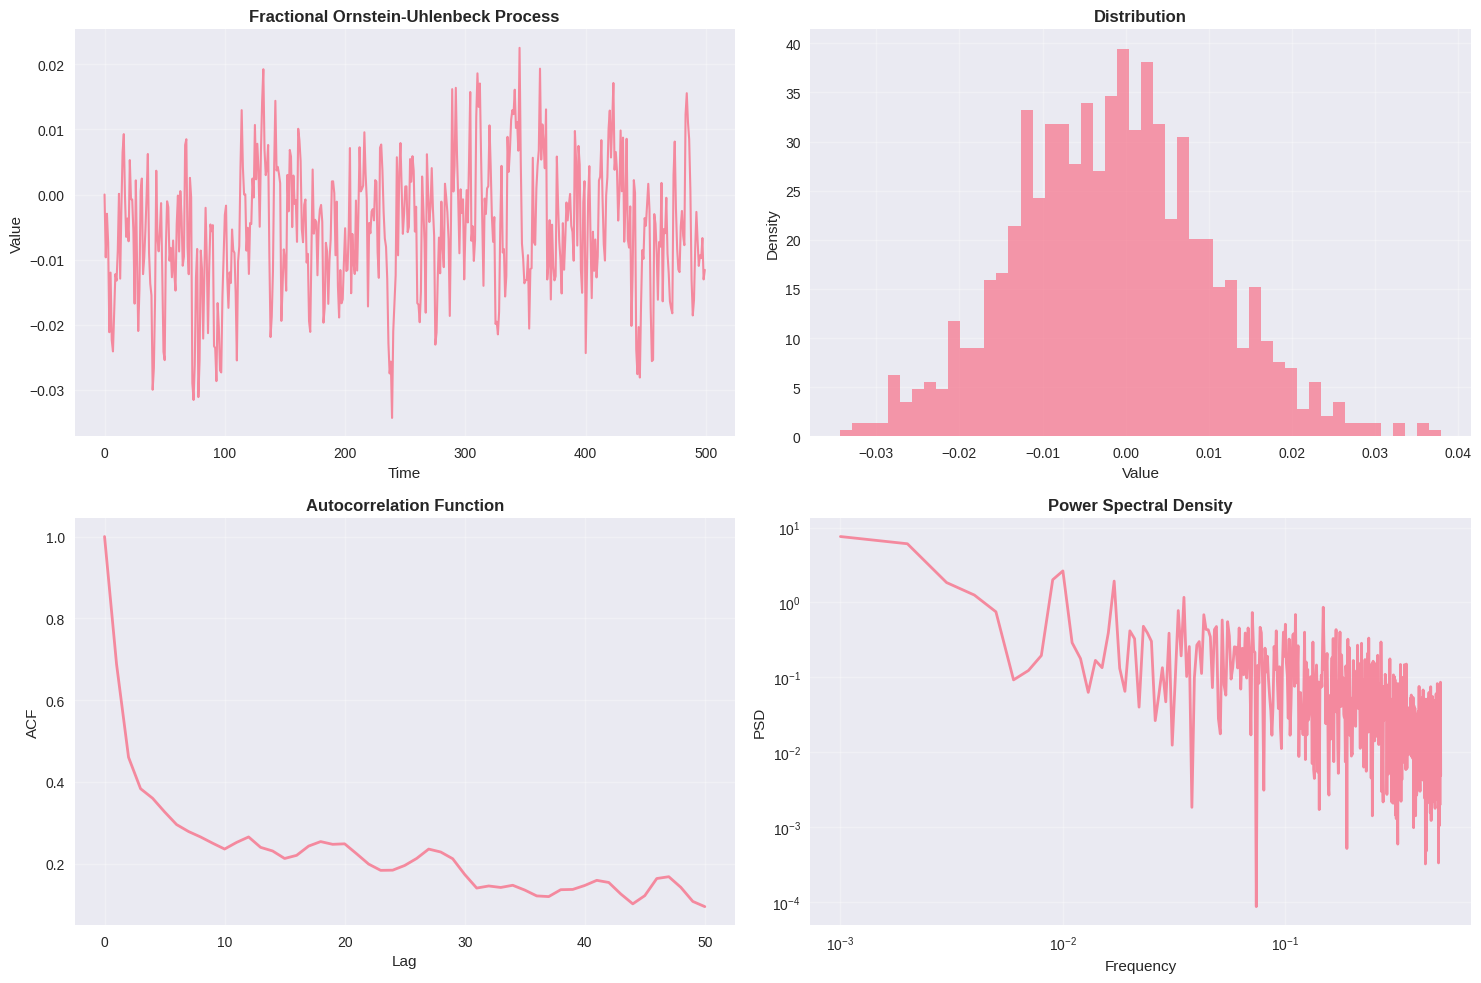


✅ Custom data model created and tested successfully!


In [10]:
class FractionalOrnsteinUhlenbeck(BaseModel):
    """
    Custom Fractional Ornstein-Uhlenbeck Process.
    
    This process combines mean reversion with long-range dependence:
    dX_t = -θ(X_t - μ)dt + σ dB_H(t)
    
    where:
    - θ: mean reversion speed
    - μ: long-term mean
    - σ: volatility
    - B_H(t): fractional Brownian motion with Hurst parameter H
    """
    
    def __init__(self, theta=0.1, mu=0.0, sigma=1.0, H=0.7, **kwargs):
        """
        Initialize the Fractional Ornstein-Uhlenbeck process.
        
        Parameters
        ----------
        theta : float
            Mean reversion speed (must be > 0)
        mu : float
            Long-term mean
        sigma : float
            Volatility (must be > 0)
        H : float
            Hurst parameter (0 < H < 1)
        """
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.H = H
        
        # Store parameters for base class
        super().__init__(theta=theta, mu=mu, sigma=sigma, H=H, **kwargs)
    
    def _validate_parameters(self):
        """Validate the model parameters."""
        if self.theta <= 0:
            raise ValueError("Mean reversion speed theta must be positive")
        if self.sigma <= 0:
            raise ValueError("Volatility sigma must be positive")
        if not (0 < self.H < 1):
            raise ValueError("Hurst parameter H must be in (0, 1)")
    
    def generate(self, n, seed=None):
        """
        Generate n samples from the Fractional Ornstein-Uhlenbeck process.
        
        Parameters
        ----------
        n : int
            Number of samples to generate
        seed : int, optional
            Random seed for reproducibility
            
        Returns
        -------
        np.ndarray
            Generated time series
        """
        if seed is not None:
            np.random.seed(seed)
        
        # Generate fractional Brownian motion
        fbm = FractionalBrownianMotion(H=self.H, sigma=1.0)
        fbm_path = fbm.generate(n, seed=seed)
        
        # Apply Ornstein-Uhlenbeck transformation
        dt = 1.0 / n  # Time step
        x = np.zeros(n)
        x[0] = self.mu  # Start at long-term mean
        
        for i in range(1, n):
            # Euler-Maruyama discretization
            dx = -self.theta * (x[i-1] - self.mu) * dt + self.sigma * (fbm_path[i] - fbm_path[i-1])
            x[i] = x[i-1] + dx
        
        return x
    
    def get_theoretical_properties(self):
        """
        Get theoretical properties of the process.
        
        Returns
        -------
        dict
            Dictionary containing theoretical properties
        """
        return {
            'mean': self.mu,
            'variance': self.sigma**2 / (2 * self.theta),
            'autocorrelation_time': 1 / self.theta,
            'hurst_parameter': self.H,
            'mean_reversion_speed': self.theta,
            'long_term_mean': self.mu,
            'volatility': self.sigma
        }
    
    def __str__(self):
        return f"FractionalOrnsteinUhlenbeck(theta={self.theta}, mu={self.mu}, sigma={self.sigma}, H={self.H})"

# Test the custom model
print("🧪 Testing Custom Fractional Ornstein-Uhlenbeck Model:")
print("=" * 60)

# Create model instance
fou = FractionalOrnsteinUhlenbeck(theta=0.1, mu=0.0, sigma=1.0, H=0.7)
print(f"Model: {fou}")

# Generate sample data
n_samples = 1000
data = fou.generate(n_samples, seed=42)

# Print basic statistics
print(f"\n📊 Generated data statistics:")
print(f"  Length: {len(data)}")
print(f"  Mean: {data.mean():.4f}")
print(f"  Std: {data.std():.4f}")
print(f"  Min: {data.min():.4f}")
print(f"  Max: {data.max():.4f}")

# Get theoretical properties
theoretical = fou.get_theoretical_properties()
print(f"\n🧮 Theoretical properties:")
for key, value in theoretical.items():
    print(f"  {key}: {value:.4f}")

# Visualize the data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Time series
axes[0, 0].plot(data[:500], linewidth=1.5, alpha=0.8)
axes[0, 0].set_title('Fractional Ornstein-Uhlenbeck Process', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Value')
axes[0, 0].grid(True, alpha=0.3)

# Distribution
axes[0, 1].hist(data, bins=50, density=True, alpha=0.7)
axes[0, 1].set_title('Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Density')
axes[0, 1].grid(True, alpha=0.3)

# Autocorrelation
from statsmodels.tsa.stattools import acf
acf_values = acf(data, nlags=50, fft=True)
axes[1, 0].plot(acf_values, linewidth=2, alpha=0.8)
axes[1, 0].set_title('Autocorrelation Function', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Lag')
axes[1, 0].set_ylabel('ACF')
axes[1, 0].grid(True, alpha=0.3)

# Power spectral density
freqs = np.fft.fftfreq(n_samples)[:n_samples//2]
psd = np.abs(np.fft.fft(data))**2
psd = psd[:n_samples//2]
axes[1, 1].loglog(freqs[1:], psd[1:], linewidth=2, alpha=0.8)
axes[1, 1].set_title('Power Spectral Density', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Frequency')
axes[1, 1].set_ylabel('PSD')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/custom_fou_model.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Custom data model created and tested successfully!")


## 4. Custom Classical Estimator {#custom-classical}

Let's create a custom classical estimator: **Variance-Based Hurst Estimator**. This is a simple but effective method based on the scaling of variance with time.


In [11]:
class VarianceBasedHurstEstimator:
    """
    Custom Variance-Based Hurst Estimator.
    
    This estimator uses the scaling relationship:
    Var(X_t) ∝ t^(2H)
    
    where H is the Hurst parameter.
    """
    
    def __init__(self, min_scale=10, max_scale=None, num_scales=10):
        """
        Initialize the variance-based Hurst estimator.
        
        Parameters
        ----------
        min_scale : int
            Minimum time scale for analysis
        max_scale : int, optional
            Maximum time scale (default: data_length // 4)
        num_scales : int
            Number of scales to use
        """
        self.min_scale = min_scale
        self.max_scale = max_scale
        self.num_scales = num_scales
    
    def estimate(self, data):
        """
        Estimate Hurst parameter using variance scaling.
        
        Parameters
        ----------
        data : np.ndarray
            Time series data
            
        Returns
        -------
        dict
            Dictionary containing estimation results
        """
        n = len(data)
        
        # Set maximum scale if not provided
        if self.max_scale is None:
            max_scale = n // 4
        else:
            max_scale = min(self.max_scale, n // 4)
        
        # Generate scales
        scales = np.logspace(np.log10(self.min_scale), np.log10(max_scale), self.num_scales).astype(int)
        scales = np.unique(scales)  # Remove duplicates
        
        # Calculate variances for each scale
        variances = []
        valid_scales = []
        
        for scale in scales:
            if scale >= n:
                continue
                
            # Calculate variance for this scale
            var_scale = self._calculate_variance_at_scale(data, scale)
            if var_scale > 0:
                variances.append(var_scale)
                valid_scales.append(scale)
        
        if len(variances) < 3:
            return {'hurst_parameter': None, 'error': 'Insufficient data for estimation'}
        
        # Fit power law: log(Var) = 2H * log(t) + C
        log_scales = np.log(valid_scales)
        log_variances = np.log(variances)
        
        # Linear regression
        coeffs = np.polyfit(log_scales, log_variances, 1)
        H_estimate = coeffs[0] / 2.0
        
        # Calculate R-squared
        y_pred = coeffs[0] * log_scales + coeffs[1]
        ss_res = np.sum((log_variances - y_pred) ** 2)
        ss_tot = np.sum((log_variances - np.mean(log_variances)) ** 2)
        r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        
        return {
            'hurst_parameter': H_estimate,
            'r_squared': r_squared,
            'scales_used': len(valid_scales),
            'method': 'Variance-Based'
        }
    
    def _calculate_variance_at_scale(self, data, scale):
        """Calculate variance at a specific time scale."""
        n = len(data)
        if scale >= n:
            return 0
        
        # Calculate variance for non-overlapping windows
        num_windows = n // scale
        if num_windows < 2:
            return 0
        
        variances = []
        for i in range(num_windows):
            start_idx = i * scale
            end_idx = start_idx + scale
            window_data = data[start_idx:end_idx]
            if len(window_data) > 0:
                variances.append(np.var(window_data))
        
        return np.mean(variances) if variances else 0

# Test the custom estimator
print("🧪 Testing Custom Variance-Based Hurst Estimator:")
print("=" * 60)

# Create estimator
variance_estimator = VarianceBasedHurstEstimator(min_scale=10, num_scales=15)

# Test on FBM data with known H
H_test = 0.7
fbm = FractionalBrownianMotion(H=H_test, sigma=1.0)
test_data = fbm.generate(1000, seed=42)

# Estimate Hurst parameter
result = variance_estimator.estimate(test_data)

print(f"Test data: FBM with H = {H_test}")
print(f"Estimated H: {result['hurst_parameter']:.4f}")
print(f"Error: {abs(result['hurst_parameter'] - H_test):.4f}")
print(f"R-squared: {result['r_squared']:.4f}")
print(f"Scales used: {result['scales_used']}")

# Compare with R/S estimator
rs_estimator = RSEstimator()
rs_result = rs_estimator.estimate(test_data)
rs_H = rs_result.get('hurst_parameter', rs_result.get('H', None))

print(f"\nComparison with R/S estimator:")
print(f"R/S H: {rs_H:.4f}")
print(f"R/S Error: {abs(rs_H - H_test):.4f}")

print("\n✅ Custom classical estimator created and tested successfully!")


🧪 Testing Custom Variance-Based Hurst Estimator:
Test data: FBM with H = 0.7
Estimated H: 0.0756
Error: 0.6244
R-squared: 0.9606
Scales used: 15

Comparison with R/S estimator:
R/S H: 0.7817
R/S Error: 0.0817

✅ Custom classical estimator created and tested successfully!


## 5. Summary and Next Steps

### Key Takeaways

1. **Extensibility**: LRDBenchmark is designed to be highly extensible with clear interfaces for custom components.

2. **Custom Data Models**: Inherit from BaseModel and implement required methods.

3. **Custom Estimators**: Follow standard interface and return consistent results.

4. **Integration**: Custom components work with existing benchmark system.

### Best Practices

- Parameter validation
- Error handling  
- Documentation
- Testing
- Performance consideration
- Compatibility

### Next Steps

1. Test custom components in benchmark system
2. Apply to real-world data
3. Explore advanced features
4. Share with community

---

**Next Notebook**: [04_comprehensive_benchmarking.ipynb](04_comprehensive_benchmarking.ipynb) - Learn how to use the comprehensive benchmarking system.
